In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import timedelta
cur_path = "C:\\Users\\ashis\\OneDrive\\Desktop\\Anchored_Vwap_Code\\"


# Function to parse the date string
def parse_date(date_str):
    # Split the string to extract the date part without timezone
    date_part = date_str.split(' GMT')[0]
    # Parse the date using the specified format
    return datetime.strptime(date_part, '%a %b %d %Y %H:%M:%S')


def num_days_in_dataframe(df):
    # Convert the date strings to datetime objects
    start_date_str = str(df['parsed_date'].iloc[0])
    end_date_str = str(df['parsed_date'].iloc[-1])
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    # Calculate the difference between end_date and start_date
    date_difference = end_date - start_date
    # Extract the number of days from the difference
    number_of_days = date_difference.days
    return number_of_days


def get_anchors_from_dataframe(df):
    # Find the highest value in the 'high' column
#     df['High'] = pd.to_numeric(df['High'], errors='coerce')
    
    df_copy = df.copy()
    df_copy['High'] = pd.to_numeric(df_copy['High'], errors='coerce')
    
    highest_high = df_copy['High'].max()
    
    # Find the index (row) where the highest value occurs
    index_of_highest_high = df_copy['High'].idxmax()
#     print(f"The highest value in the 'high' column is: {highest_high}")
#     print(f"The index of the highest value is: {index_of_highest_high}")

    return highest_high, index_of_highest_high


def fetch_data():
    
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 5min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46000ce 5 min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46500ce 15min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\10 aug 46500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46500ce 5min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46000ce 5 min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 46500ce 5min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\17 aug 45500ce 5min.csv', skiprows=2)

#     df = pd.read_csv(cur_path + 'option_data\\7 sep 45000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\7 sep 45500ce 15min.csv', skiprows=2)
    df = pd.read_csv(cur_path + 'option_data\\7 sep 46000ce 15min.csv', skiprows=2)
#     df = pd.read_csv(cur_path + 'option_data\\24 aug 46000ce 15min.csv', skiprows=2)
    df.columns = ["Open", "High", "Low", "Close", "Volume","OpenInterest", "temp"]
    df.drop(["temp"], axis = 1, inplace = True)
    df['parsed_date'] = df.index.to_series().apply(parse_date)
    return df

def convert_index_to_datetime(df):
    index = [datetime.strptime(date, "%a %b %d %Y %H:%M:%S %Z%z (India Standard Time)") for date in df.index]
    df = pd.DataFrame(df.values, columns=df.columns, index=index)
    return df

def get_n_days_data_from_dataframe(df, days ):
    n = days
    end_date = df["parsed_date"].max()
    start_date = end_date - timedelta(days = n)
    n_days_data = df[df['parsed_date'] >= start_date]
    return n_days_data

def get_multiple_anchors_from_dataframe(train_data):
    num_days = num_days_in_dataframe(train_data)
    if num_days < 9:
        a,b= get_anchors_from_dataframe(train_data)
        return [[a,b]]
    elif 9 <= num_days <= 17:
        global_anchor, global_anchor_timeframe = get_anchors_from_dataframe(train_data)
        
        seven_days_data = get_n_days_data_from_dataframe(train_data, 7)
        seven_day_anchor, seven_day_anchor_timeframe = get_anchors_from_dataframe(seven_days_data)
        return [[global_anchor, global_anchor_timeframe],[seven_day_anchor, seven_day_anchor_timeframe]]
    elif num_days>=17:
        global_anchor, global_anchor_timeframe = get_anchors_from_dataframe(train_data)
        seven_days_data = get_n_days_data_from_dataframe(train_data, 7)
        seven_day_anchor, seven_day_anchor_timeframe = get_anchors_from_dataframe(seven_days_data)
        two_weeks_data = get_n_days_data_from_dataframe(train_data, 14)
        two_weeks_data_anchor, two_weeks_data_anchor_timeframe = get_anchors_from_dataframe(two_weeks_data)
        return [[global_anchor, global_anchor_timeframe],[two_weeks_data_anchor, two_weeks_data_anchor_timeframe],[seven_day_anchor, seven_day_anchor_timeframe]]
    else:
        return None
    
    
def test_temp():
    df = fetch_data()

    # Example usage:
    split_index = int(0.8 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer


    output = get_multiple_anchors_from_dataframe(train_data)
    print(num_days_in_dataframe(train_data))
    print(output)
    


def backtest_actual():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.3 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    
    print(f"len_train_data: {len(train_data)} ,,, len_test_data: {len(test_data)} ")
    
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    # Convert OHLCV values to float/int for vwap calculations
    train_data['Open'] = train_data['Open'].astype(float)
    train_data['High'] = train_data['High'].astype(float)
    train_data['Low'] = train_data['Low'].astype(float)
    train_data['Close'] = train_data['Close'].astype(float)
    train_data['Volume'] = train_data['Volume'].astype(int)  # If Volume is expected to be an integer
#     lower_range_arr = []
#     upper_range_arr = []

    ####################### Code to buy / sell ################################
    
    
    profit_threshold = 0.75  # 75% profit threshold
    loss_threshold = -0.25  # 25% loss threshold (negative value)
    total_pnl = 0  # Initialize total P&L
    amount_to_invest = 10000  # Initial investment amount
    stop_loss_percentage = 0.01  # 1% stop loss
    positions_dictionary = {}
    
    buy_price_dictionary = {}
    sell_price_dictionary = {}
    anchors = get_multiple_anchors_from_dataframe(train_data)
    print(anchors)
    for idx in range(len(test_data)):
        # Test data candle -> Append to Train data 
        # Calculate Anchored Vwap for the new Train_Data
        # Check if current_candle_close is in range of AnchoredVwap
        # if it is, Buy condition 
        
        candle_data = test_data.iloc[idx]
        
        
        # Check if it's past 3:00 pm and exit all existing positions
        current_time = pd.Timestamp(candle_data["parsed_date"]).time()
        if current_time >= pd.Timestamp("15:00:00").time():
            for anchor_value, anchor_time in anchors:
                if positions_dictionary[anchor_time] == "sell":
                    positions_dictionary[anchor_time] = "buy"
                    pnl = sell_price_dictionary[anchor_time] - current_close_price
                    total_pnl += pnl
                    print("Found a BUY SIGNAL (End of Day)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Buy Price: " + str(current_close_price))
                    print("P&L: {:.2f}".format(pnl))
                    print("End of day " + str(current_time)+". Total P&L: {:.2f}".format(total_pnl))
                    print("---------------------------------------------------------------------")
                    print()
                # Reset position to None
                positions_dictionary[anchor_time] = None
        
        
            
            
        parsed_date = candle_data["parsed_date"]
        row_to_append_df = pd.DataFrame([candle_data], columns=train_data.columns)
        train_data = pd.concat([train_data, row_to_append_df])
        
        # Check if the time is within the intraday trading window (9:20 am to 3:00 pm)
        trading_start_time = parsed_date.replace(hour=9, minute=20, second=0)
        trading_end_time = parsed_date.replace(hour=15, minute=0, second=0)
        ################### Multiple anchors code
#         anchors = get_multiple_anchors_from_dataframe(train_data)
        
#         print(f"No of anchor {len(anchors)}")
        if parsed_date < trading_start_time:
            continue  # Skip this data point if before 9:20 am
        elif parsed_date >= trading_end_time:
            continue  # Stop trading if it's 3:00 pm or later
        for anchor_value, anchor_time in anchors:
#             print(f"working on anchor {anchor_time}")
            if(anchor_time in positions_dictionary.keys()):
                pass
            else:
                print("setting to none")
                print(f" {anchor_time} not found in vault")
                positions_dictionary[anchor_time] = None
                buy_price_dictionary[anchor_time] = None
                sell_price_dictionary[anchor_time] = None
            
#             anchor_value, anchor_time = get_anchors_from_dataframe(train_data)
            anchor_timeframe = anchor_time

            anchor_vwap = train_data.loc[anchor_timeframe:]['Volume'].mul(train_data.loc[anchor_timeframe:]['Close']).cumsum() / \
                          train_data.loc[anchor_timeframe:]['Volume'].cumsum()

            x = len(train_data)
            y = len(anchor_vwap)
            nans = int(x-y)
            nan_values = pd.Series([np.nan] * nans , dtype=float)
    #         extended_series = pd.concat([nan_values, anchor_vwap])
            anchor_vwap = pd.concat([nan_values, anchor_vwap])
            

            current_close_price = float(candle_data["Close"])
            current_anchor = float(anchor_vwap.iloc[-1])
            lower_range = current_anchor * 0.85
            upper_range = current_anchor * 1.15
            
            ############################ Buy / sell code conditions ###########################
            if positions_dictionary[anchor_time] is None:
                # First condition is always a sell when there's no position
                if lower_range <= current_close_price:
                    sell_price_dictionary[anchor_time] = current_close_price
                    positions_dictionary[anchor_time] = "sell"
                    print("Found a SELL SIGNAL (First Signal)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Sell Price: " + str(sell_price_dictionary[anchor_time]))
            elif positions_dictionary[anchor_time] == "sell":
                if (sell_price_dictionary[anchor_time] - current_close_price) >= (profit_threshold * sell_price_dictionary[anchor_time]):
                    # Buy when profit reaches 25%
                    positions_dictionary[anchor_time] = "buy"
                    pnl = sell_price_dictionary[anchor_time] - current_close_price
                    total_pnl += pnl
                    print("Found a BUY SIGNAL (Profit)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Buy Price: " + str(current_close_price))
                    print("P&L: {:.2f}".format(pnl))
                elif (sell_price_dictionary[anchor_time] - current_close_price) <= (loss_threshold * sell_price_dictionary[anchor_time]):
                    # Buy when loss reaches 25%
                    positions_dictionary[anchor_time] = "buy"
                    pnl = sell_price_dictionary[anchor_time] - current_close_price
                    total_pnl += pnl
                    print("Found a BUY SIGNAL (Loss)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Buy Price: " + str(current_close_price))
                    print("P&L: {:.2f}".format(pnl))
                elif (total_pnl + (sell_price_dictionary[anchor_time] - current_close_price)) <= -(stop_loss_percentage * amount_to_invest):
                    # Exit position completely if total loss exceeds 1% of amount_to_invest
                    positions_dictionary[anchor_time] = "buy"
                    pnl = sell_price_dictionary[anchor_time] - current_close_price
                    total_pnl += pnl
                    print("Found a BUY SIGNAL (Stop Loss)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Buy Price: " + str(current_close_price))
                    print("P&L: {:.2f}".format(pnl))
                    print("Stop Loss Hit. Total Loss: {:.2f}".format(total_pnl))
            elif positions_dictionary[anchor_time] == "buy":
                # Check for take profit
                if total_pnl >= (profit_threshold * amount_to_invest):
                    positions_dictionary[anchor_time] = "buy"
                    pnl = sell_price_dictionary[anchor_time] - current_close_price
                    total_pnl += pnl
                    print("Found a BUY SIGNAL (Take Profit)")
                    print("Date: " + str(candle_data["parsed_date"]))
                    print("Buy Price: " + str(current_close_price))
                    print("P&L: {:.2f}".format(pnl))
                    print("Take Profit Hit. Total Profit: {:.2f}".format(total_pnl))
        
    for anchor_value, anchor_time in anchors:
        # Ensure the last position is a buy if not already
        if positions_dictionary[anchor_time] == "sell":
            positions_dictionary[anchor_time] = "buy"
            pnl = sell_price_dictionary[anchor_time] - current_close_price
            total_pnl += pnl
            print("Found a BUY SIGNAL (End of Data)")
            print("Date: " + str(candle_data["parsed_date"]))
            print("Buy Price: " + str(current_close_price))
            print("P&L: {:.2f}".format(pnl))
            print("End of Data. Total P&L: {:.2f}".format(total_pnl))

    print("Total P&L: {:.2f}".format(total_pnl))
    
    ############################ Buy / sell code conditions ###########################
    
#     x = len(train_data)
#     y = len(lower_range_arr)
#     nans = int(x-y)
#     nan_values = pd.Series([np.nan] * nans, dtype=float)
# #     lower_range_arr = pd.concat([nan_values, pd.Series(lower_range_arr)])
# #     upper_range_arr = pd.concat([nan_values, pd.Series(upper_range_arr)])
#     apd = mpf.make_addplot( anchor_vwap.values, color='blue', title='Anchored VWAP')
# #     apd1 = mpf.make_addplot( lower_range_arr, color='red', title='asdf VWAP')
# #     apd2 = mpf.make_addplot( upper_range_arr, color='green', title='da VWAP')
# #     mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1, apd2])
#     mpf.plot(train_data, type='candle', style='yahoo', volume=True, addplot=[apd, apd1])
#     plt.show()

def backtest():
    df = fetch_data()
    number_of_days = num_days_in_dataframe(df)
    print(f"Number of days in the date range: {number_of_days} days")

    # Calculate the index at which to split the data (70% for training)
    split_index = int(0.7 * len(df))

    # Split the DataFrame into training and testing sets
    train_data = df.iloc[:split_index]  # First 70% of the data
    test_data = df.iloc[split_index:]  # Remaining 30% of the data
    train_data = convert_index_to_datetime(train_data)
    test_data = convert_index_to_datetime(test_data)
    
    backtest_actual()


def strategy_main():
    backtest_actual()
#     test_temp()


if __name__ == '__main__':
    strategy_main()


C:\Users\ashis\AppData\Local\Temp\ipykernel_9672\1194047481.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Number of days in the date range: 23 days
len_train_data: 115 ,,, len_test_data: 270 
[[354.75, Timestamp('2023-08-09 13:45:00+0530', tz='GMT')]]
setting to none
 2023-08-09 13:45:00+05:30 not found in vault
Found a SELL SIGNAL (First Signal)
Date: 2023-08-23 12:15:00
Sell Price: 29.55
Found a BUY SIGNAL (Loss)
Date: 2023-08-23 12:45:00
Buy Price: 37.15
P&L: -7.60
Found a SELL SIGNAL (First Signal)
Date: 2023-08-24 09:30:00
Sell Price: 65.4
Found a BUY SIGNAL (End of Day)
Date: 2023-08-24 15:00:00
Buy Price: 39.55
P&L: 25.85
End of day 15:00:00. Total P&L: 18.25
---------------------------------------------------------------------

Total P&L: 18.25


{'Success': {'bank_account': '50100245203415', 'total_bank_balance': 21.93, 'allocated_equity': 21.93, 'allocated_fno': 0.0, 'block_by_trade_equity': 0.0, 'block_by_trade_fno': 0.0, 'block_by_trade_balance': 0.0, 'unallocated_balance': '0'}, 'Status': 200, 'Error': None}
Expiry date for 19-4-2023 is 2023-04-27 00:00:00
Day's 19-4-2023 first candle LTP : 17626.55
___________________________Working on Strike : 17700_______________________________


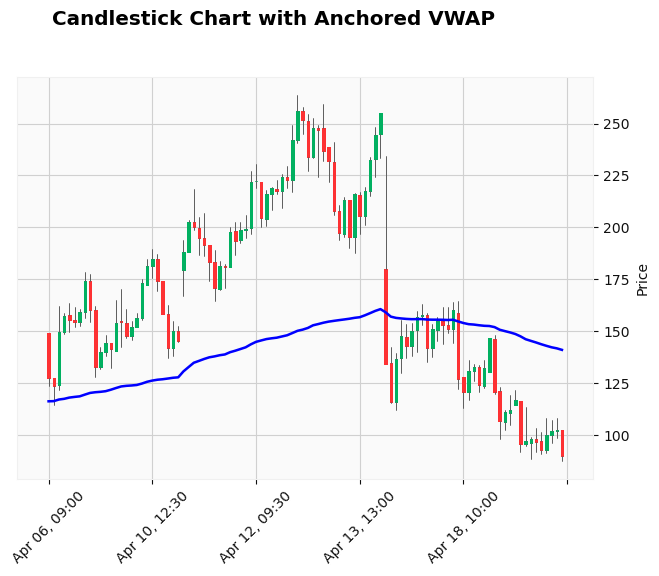

here
___________________________Working on Strike : 17800_______________________________


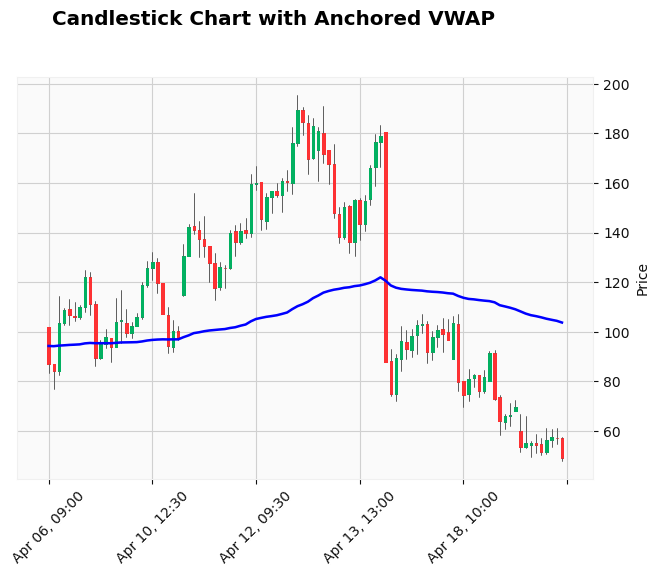

here


KeyboardInterrupt: 